In [34]:
import cv2 as cv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report

import os

In [2]:
data = []

for filename in os.listdir("Data/RawImgs/"):
  img = cv.imread("Data/RawImgs/" + filename)
  img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
  low_color = np.array([55, 55, 152])
  high_color = np.array([166, 153, 255])
  img2 = cv.cvtColor(img, cv.COLOR_RGB2HSV)
  mask = cv.inRange(img2, low_color, high_color)

  contours, _ = cv.findContours(mask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
  contour = max(contours, key=cv.contourArea)

  M = cv.moments(contour)
  cX = int(M["m10"]/M["m00"])
  cY = int(M["m01"]/M["m00"])


  # Define the translation matrix
  tx = 100-cX  # Translation in x direction
  ty = 100-cY # Translation in y direction
  M = np.float32([[1, 0, tx], [0, 1, ty]])

  # Apply the translation
  translated_image = cv.warpAffine(mask, M, (200, 200))
  resized_image = cv.resize(translated_image, (60, 60))

  cv.imwrite("Data/ProcessedImg/" + filename, resized_image)

  data.append({"filename": filename, "data": resized_image.reshape(1,3600)[0]})

In [3]:
df = pd.DataFrame(data)
df2 = pd.DataFrame(df["data"].to_list())
df = pd.concat([df,df2], axis=1)
df = df.drop(columns=["data"])
df.to_csv("pixels_fam.csv")

In [4]:
df = pd.read_csv("pixels_fam.csv")
df

,Unnamed: 0,filename,0,1,2,3,4,5,6,7,...,3590,3591,3592,3593,3594,3595,3596,3597,3598,3599
0,0,BloodImage_00329.jpg,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,BloodImage_00315.jpg,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,BloodImage_00301.jpg,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,BloodImage_00117.jpg,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,BloodImage_00063.jpg,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
340,340,BloodImage_00126.jpg,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
341,341,BloodImage_00132.jpg,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
342,342,BloodImage_00318.jpg,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
343,343,BloodImage_00324.jpg,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
df3 = pd.read_csv("Data/WBC_Labels.csv")
df3["FILENAME"] = df3["FILENAME"].str.strip("'")

df3.set_index("FILENAME", inplace=True)
df.set_index("filename", inplace=True)
df = pd.concat([df, df3], axis=1)

In [23]:
from sklearn.model_selection import train_test_split

X = df.iloc[:,1:3601]
y = df["FAMILY"]
y = pd.get_dummies(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, stratify=y)
X_val, _, y_val, _ = train_test_split(X_test, y_test, train_size=0.2, stratify=y_test)

In [24]:
y = pd.get_dummies(y)
y

,GRANULOCYTE,LYMPHOCYTE,MONOCYTE
BloodImage_00329.jpg,True,False,False
BloodImage_00315.jpg,True,False,False
BloodImage_00301.jpg,True,False,False
BloodImage_00117.jpg,False,False,True
BloodImage_00063.jpg,True,False,False
...,...,...,...
BloodImage_00126.jpg,True,False,False
BloodImage_00132.jpg,True,False,False
BloodImage_00318.jpg,False,False,True
BloodImage_00324.jpg,True,False,False


## Try with Neural Nets

In [8]:
from keras import models
from keras import layers
from keras import optimizers

import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

In [25]:
model = models.Sequential()

model.add(layers.Dense(60, activation='relu', input_shape=(3600,)))
model.add(layers.Dense(30, activation='relu'))
model.add(layers.Dense(3, activation='softmax'))

model.compile(optimizer=optimizers.SGD(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)
X_val = ss.transform(X_val)

In [26]:
history = model.fit(X_train, y_train, epochs=2048, batch_size=256, validation_data=(X_val, y_val))

Epoch 1/2048
1/2 [==============>...............] - ETA: 0s - loss: 2.4606 - accuracy: 0.1016

2024-11-12 14:57:15.156632: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-11-12 14:57:15.371733: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 1s 338ms/step - loss: 2.4546 - accuracy: 0.1014 - val_loss: 3.8692 - val_accuracy: 0.0769
Epoch 2/2048
2/2 [==============================] - 0s 38ms/step - loss: 2.3565 - accuracy: 0.1051 - val_loss: 3.7908 - val_accuracy: 0.0769
Epoch 3/2048
2/2 [==============================] - 0s 33ms/step - loss: 2.2716 - accuracy: 0.1304 - val_loss: 3.7072 - val_accuracy: 0.0769
Epoch 4/2048
2/2 [==============================] - 0s 34ms/step - loss: 2.1848 - accuracy: 0.1377 - val_loss: 3.6176 - val_accuracy: 0.0000e+00
Epoch 5/2048
2/2 [==============================] - 0s 35ms/step - loss: 2.0890 - accuracy: 0.1341 - val_loss: 3.5403 - val_accuracy: 0.0769
Epoch 6/2048
2/2 [==============================] - 0s 34ms/step - loss: 2.0083 - accuracy: 0.1449 - val_loss: 3.4698 - val_accuracy: 0.1538
Epoch 7/2048
2/2 [==============================] - 0s 35ms/step - loss: 1.9453 - accuracy: 0.1630 - val_loss: 3.3937 - val_accuracy: 0.1538
Epoch 8/2048
2/2 [===

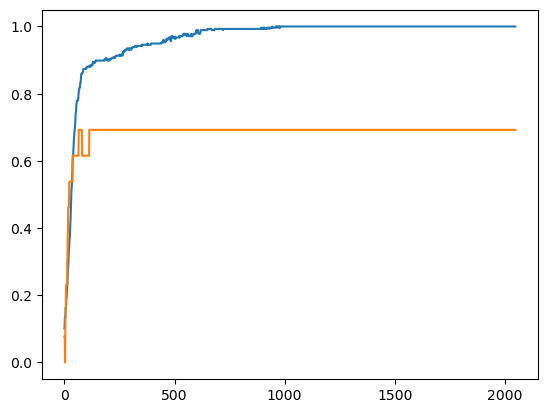

In [27]:
fig, ax = plt.subplots()
ax.plot(history.history["accuracy"])
ax.plot(history.history["val_accuracy"])

In [28]:
model.evaluate(X_train, y_train)

9/9 [==============================] - 0s 17ms/step - loss: 0.0224 - accuracy: 1.0000


[0.022438928484916687, 1.0]

In [29]:
model.evaluate(X_test, y_test)

3/3 [==============================] - 0s 23ms/step - loss: 0.5888 - accuracy: 0.7826


[0.5888449549674988, 0.782608687877655]

In [30]:
y_test_pred = model.predict(X_test)

3/3 [==============================] - 0s 9ms/step


2024-11-12 14:59:26.831679: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [31]:
y_test_pred_2 = []
for x in y_test_pred:
    if (x[0] > x[1]) and (x[0] > x[2]):
        y_test_pred_2.append("GRANULOCYTE")
    elif (x[1] > x[0]) and (x[1] > x[2]):
        y_test_pred_2.append("LYMPHOCYTE")
    else:
        y_test_pred_2.append("MONOCYTE")
y_test_pred_2

['GRANULOCYTE',
 'GRANULOCYTE',
 'GRANULOCYTE',
 'GRANULOCYTE',
 'GRANULOCYTE',
 'GRANULOCYTE',
 'GRANULOCYTE',
 'GRANULOCYTE',
 'GRANULOCYTE',
 'GRANULOCYTE',
 'GRANULOCYTE',
 'GRANULOCYTE',
 'GRANULOCYTE',
 'GRANULOCYTE',
 'GRANULOCYTE',
 'GRANULOCYTE',
 'GRANULOCYTE',
 'GRANULOCYTE',
 'GRANULOCYTE',
 'GRANULOCYTE',
 'GRANULOCYTE',
 'GRANULOCYTE',
 'GRANULOCYTE',
 'GRANULOCYTE',
 'GRANULOCYTE',
 'GRANULOCYTE',
 'GRANULOCYTE',
 'GRANULOCYTE',
 'GRANULOCYTE',
 'GRANULOCYTE',
 'GRANULOCYTE',
 'GRANULOCYTE',
 'GRANULOCYTE',
 'MONOCYTE',
 'GRANULOCYTE',
 'GRANULOCYTE',
 'GRANULOCYTE',
 'GRANULOCYTE',
 'MONOCYTE',
 'GRANULOCYTE',
 'GRANULOCYTE',
 'GRANULOCYTE',
 'GRANULOCYTE',
 'GRANULOCYTE',
 'GRANULOCYTE',
 'GRANULOCYTE',
 'GRANULOCYTE',
 'GRANULOCYTE',
 'GRANULOCYTE',
 'GRANULOCYTE',
 'GRANULOCYTE',
 'GRANULOCYTE',
 'GRANULOCYTE',
 'GRANULOCYTE',
 'GRANULOCYTE',
 'GRANULOCYTE',
 'GRANULOCYTE',
 'GRANULOCYTE',
 'GRANULOCYTE',
 'GRANULOCYTE',
 'GRANULOCYTE',
 'MONOCYTE',
 'GRANULOCYTE',
 

In [32]:
y_test_2 = []
for values in y_test.values:
    if values[0]:
        y_test_2.append("GRANULOCYTE")
    elif values[1]:
        y_test_2.append("LYMPHOCYTE")
    else:
        y_test_2.append("MONOCYTE")

In [33]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test_2, y_test_pred_2)

array([[54,  1,  3],
       [ 7,  0,  0],
       [ 4,  0,  0]])

In [37]:
print(classification_report(y_test_2, y_test_pred_2))

              precision    recall  f1-score   support

 GRANULOCYTE       0.83      0.93      0.88        58
  LYMPHOCYTE       0.00      0.00      0.00         7
    MONOCYTE       0.00      0.00      0.00         4

    accuracy                           0.78        69
   macro avg       0.28      0.31      0.29        69
weighted avg       0.70      0.78      0.74        69

